<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-imports-and-dfs" data-toc-modified-id="Load-imports-and-dfs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load imports and dfs</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


1. Load imports & test, train DFs
2. Apply stratified kfold & traing with lgbm and submit to kaggle
3. Check for missing data feature engineering parts missed if score > 3.7
4. Split the training set to train & validation
5. Train over RF to get a benchmark of the dataset
6. Drop irrelevant features by sorting on feature importance
7. Drop redundant features by plotting a Dendogram and removing the redundancy
8. Use a feature interpreter to see which feature is contributing lot to prediction
9. Use extrapolation to see if we can remove feature which add bias of training & validation set
10. Use partial dependence plot to see outliers/missed features
11. Submit to kaggle the RF model and see the score
11. Use stratified kfold to train the RF model and submit to kaggle
12. Repeat again with LGBM/XGBoost/Adaboost. Stack the model and submit to kaggle


### Load imports and dfs

In [2]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings

In [11]:
train_df2 = feather.read_dataframe('train_df_proc')
test_df2 = feather.read_dataframe('test_df_proc')

In [12]:
for df in [train_df2, test_df2]:
    for f in ['purchase_date_amax','purchase_date_amin','purchase_date_amax_old',\
                     'purchase_date_amin_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [13]:
df_train_columns = [c for c in train_df2.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train_df2['target']

In [14]:
target.shape

(201917,)

In [15]:
del train_df2['target']

In [16]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train_df2))
predictions = np.zeros(len(test_df2))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,train_df2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df2[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66829	valid_1's rmse: 3.728
[200]	training's rmse: 3.59023	valid_1's rmse: 3.69534
[300]	training's rmse: 3.54172	valid_1's rmse: 3.68179
[400]	training's rmse: 3.50471	valid_1's rmse: 3.67479
[500]	training's rmse: 3.47425	valid_1's rmse: 3.66959
[600]	training's rmse: 3.44854	valid_1's rmse: 3.66746
[700]	training's rmse: 3.42552	valid_1's rmse: 3.66513
[800]	training's rmse: 3.40488	valid_1's rmse: 3.66389
[900]	training's rmse: 3.38584	valid_1's rmse: 3.66333
[1000]	training's rmse: 3.36632	valid_1's rmse: 3.66294
[1100]	training's rmse: 3.34922	valid_1's rmse: 3.6627
[1200]	training's rmse: 3.33281	valid_1's rmse: 3.66242
Early stopping, best iteration is:
[1198]	training's rmse: 3.33311	valid_1's rmse: 3.66239
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66977	valid_1's rmse: 3.72125
[200]	training's rmse: 3.59197	valid_1's rmse: 3.69113

3.6619110593783413

1. Score for submission-2019-01-11 10:18:09.909061.csv - 3.6597596743401666, LB - 3.707 (included cat_1)
2. Score for submission-2019-01-12 13:53:27.215115.csv - 3.656726211308068, LB - 3.696 (jst refactored)
3. Proc_df without target encoding - 3.6624898475055954
4. With proc_df - 3.6619110593783413

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


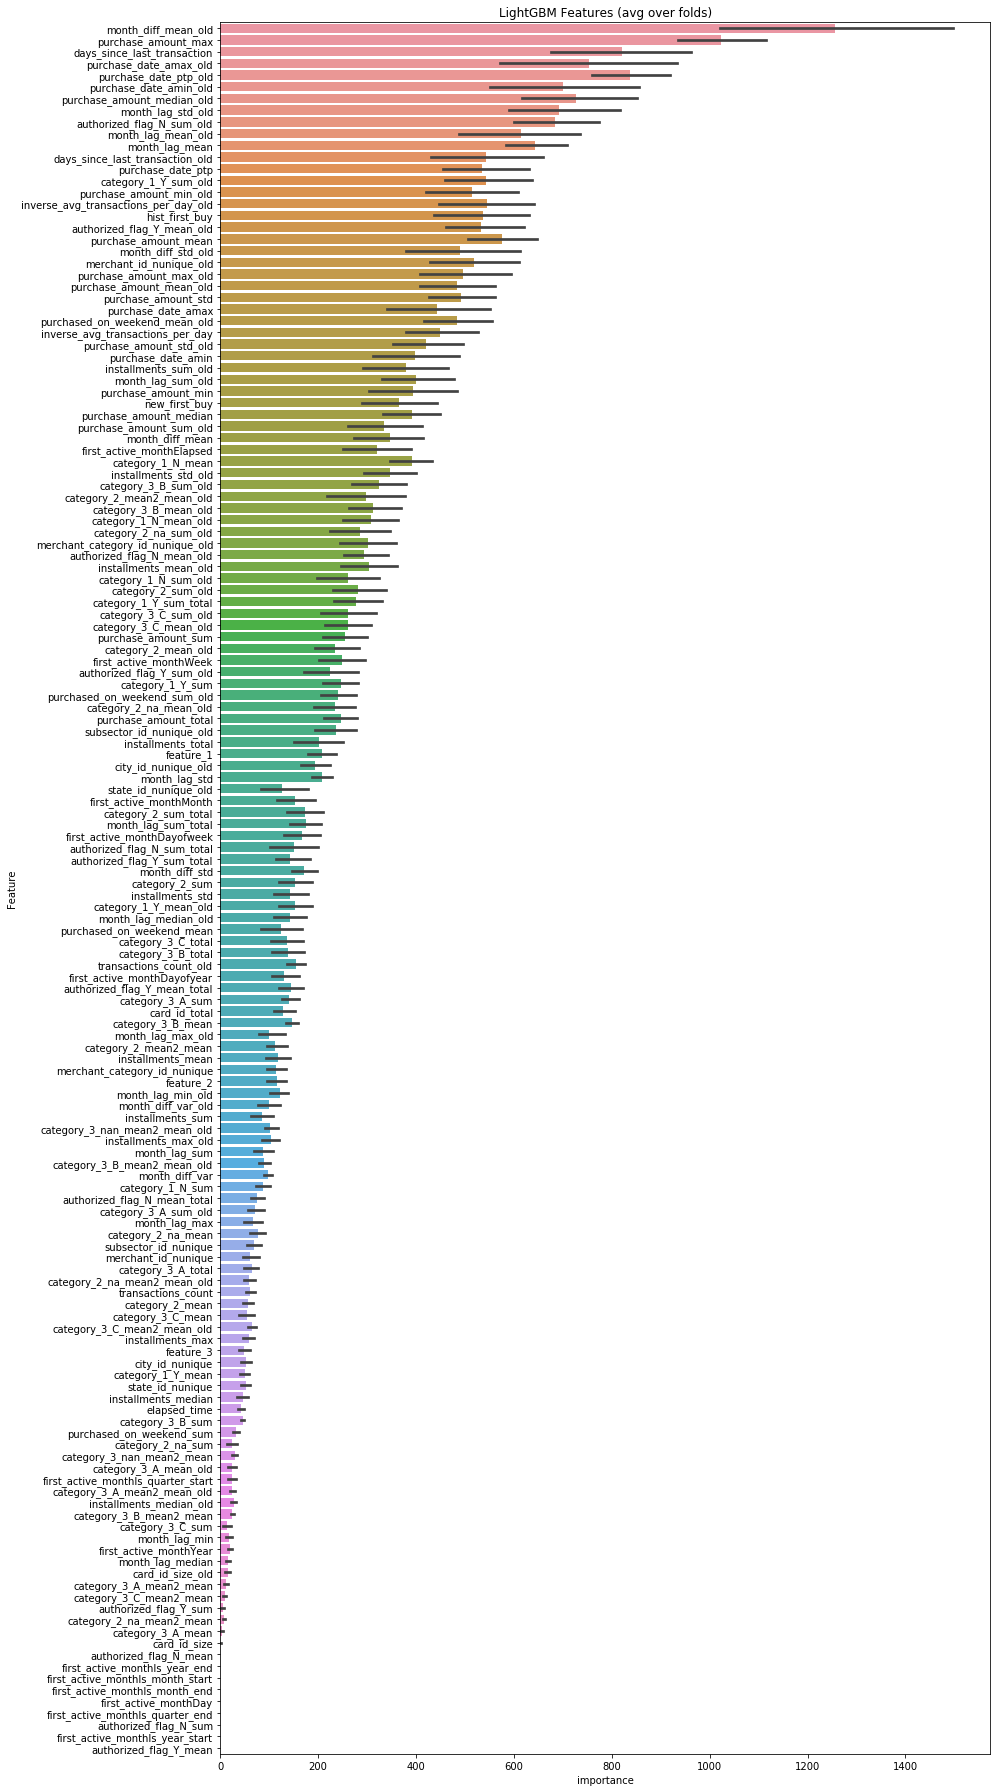

In [9]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [10]:
sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(f'submission-{pd.to_datetime("today")}.csv', index=False)

In [11]:
!ls

'Elo - ML model.ipynb'
'Elo end 2 end.ipynb'
'Elo feature engineering.ipynb'
'Elo merchant category reco - using RF.ipynb'
'TS Fresh.ipynb'
 data
 fastai
 hist_trans
 hist_trans_agg
 lgbm_importances.png
 new_hist
 new_hist_agg
 new_hist_trans
 new_hist_trans_agg
 new_merchant_transactions_df
 new_transactions_df
'submission-2019-01-11 09:49:53.716164.csv'
'submission-2019-01-11 10:18:09.909061.csv'
'submission-2019-01-12 13:53:27.215115.csv'
 test_df
 test_df2
 train_df
 train_df2


In [12]:
FileLink('./submission-2019-01-12 13:53:27.215115.csv')

/home/chandrasekhar/private/competitions/submission-2019-01-12 13:53:27.215115.csv